Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 90 rows, 1980 columns and 3960 nonzeros
Model fingerprint: 0xe8983fec
Variable types: 0 continuous, 1980 integer (1980 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 90 rows, 1980 columns, 3960 nonzeros
Variable types: 0 continuous, 1980 integer (1980 binary)

Root relaxation: objective 4.740529e+04, 129 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 47405.2891    0   20          - 47405.2891      -     -    0s
H    0     0          

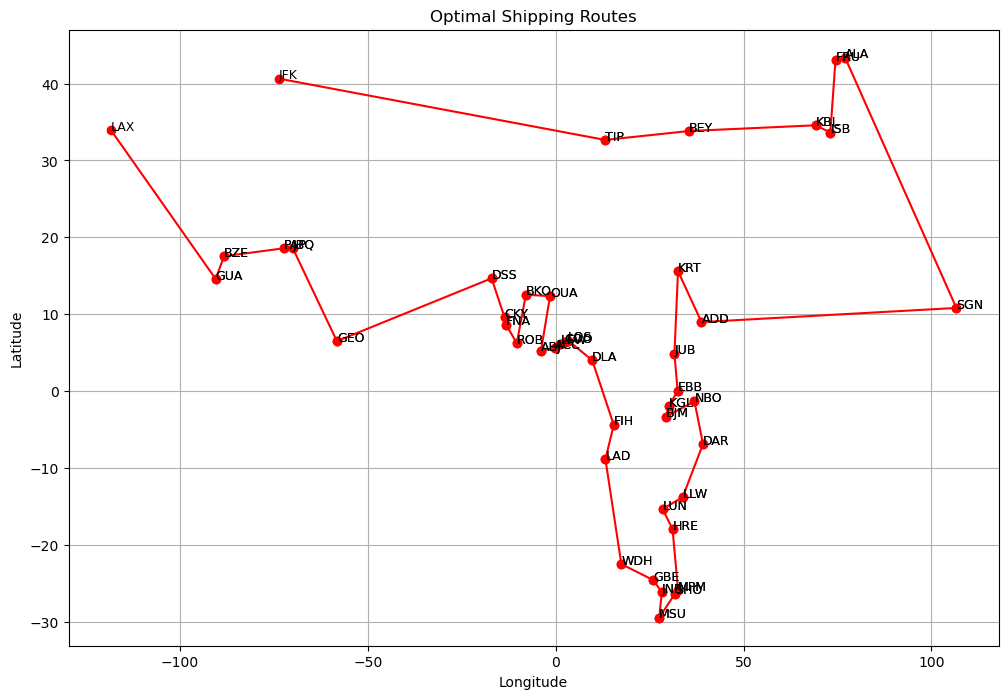

In [21]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum
from haversine import haversine, Unit
import matplotlib.pyplot as plt

data = pd.read_csv('airports.csv')
nodes = data['airport_code'].tolist()
coords = {row['airport_code']: (row['latitude_deg'], row['longitude_deg']) for _, row in data.iterrows()}
origins = ['JFK', 'LAX']  # Starting points (origins)
dests = [airport for airport in nodes if airport not in origins]  # Non-origin airports

# distances between all pairs of airports
distances = {
    (i, j): haversine(coords[i], coords[j], unit=Unit.KILOMETERS)
    for i in nodes for j in nodes if i != j
}

# Create optimization model
m = Model()

# x[i, j] = 1 if route (i - j) is selected
x = m.addVars(distances.keys(), vtype=GRB.BINARY, obj=distances, name='x')

m.modelSense = GRB.MINIMIZE

# Each destination has one income and outcome
for i in nodes:
    m.addConstr(quicksum(x[i, j] for j in nodes if j != i) == 1, name=f'out_{i}')  # Flow out of node
    m.addConstr(quicksum(x[j, i] for j in nodes if j != i) == 1, name=f'in_{i}')   # Flow into node

# Enable lazy constraints 
m.params.LazyConstraints = 1

# Callback for subtour elimination
def subtour_elimination_callback(m, where):
    if where == GRB.Callback.MIPSOL:  # Check only at integer solutions
        vals = m.cbGetSolution(x)  # Get current solution
        selected = [(i, j) for i, j in x.keys() if vals[i, j] > 0.5]  # Extract selected arcs
        subtours = find_subtours(selected, nodes)  # Detect subtours
        for subtour in subtours:
            if len(subtour) < len(nodes):  # Eliminate subtours by adding constraints
                m.cbLazy(quicksum(x[i, j] for i in subtour for j in subtour if i != j) <= len(subtour) - 1)

# Subtour detection (find cycles in the solution graph)
def find_subtours(edges, nodes):
    unvisited = set(nodes)
    subtours = []
    while unvisited:  # Traverse the graph
        current = unvisited.pop()
        tour = [current]
        neighbors = [j for i, j in edges if i == current]
        while neighbors:
            next_node = neighbors.pop()
            if next_node in unvisited:
                unvisited.remove(next_node)
                tour.append(next_node)
                neighbors.extend([j for i, j in edges if i == next_node])
        subtours.append(tour)
    return subtours

m.optimize(subtour_elimination_callback)

if m.status == GRB.OPTIMAL:
    solution = m.getAttr('x', x)
    selected_arcs = [(i, j) for (i, j) in distances.keys() if solution[i, j] > 0.5]
    total_distance = m.objVal
    print(f"Optimal Total Distance: {total_distance:.2f} km")
    print("Optimal Routes:")
    for arc in selected_arcs:
        print(f"{arc[0]} -> {arc[1]}")

    optimal_value = total_distance
    
    # Visualization 
    plt.figure(figsize=(12, 8))
    for i, j in selected_arcs:
        if (i, j) == ('JFK', 'LAX'):
            continue
        
        latitudes = [coords[i][0], coords[j][0]]
        longitudes = [coords[i][1], coords[j][1]]
        plt.plot(longitudes, latitudes, 'ro-')
        plt.text(coords[i][1], coords[i][0], i, fontsize=9)
        plt.text(coords[j][1], coords[j][0], j, fontsize=9)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Optimal Shipping Routes')
    plt.grid(True)
    plt.show()
else:
    print("No optimal solution found.")


In [22]:
distances['JFK', 'LAX']

3974.2054516289463

In [23]:
print(f'The Q1 total distance (excluding JFK to LAX) is: {(optimal_value - distances["JFK", "LAX"]):.2f} km')

The Q1 total distance (excluding JFK to LAX) is: 56828.57 km
